## PaleoSTeHM: A modern, scalable Spatio-Temporal Hierarchical Modeling framework for paleo-environmental data

Yucheng Lin - yc.lin@rutgers.edu

with Alex Reedy and Robert Kopp

## Tutorial 9: Spatio-temporal Gassusian Process (STGP) with Multiple Kernels

In the last tutorial, we talked about the basics of building a spatio-temporal (ST) GP kernel and how to perform sea-level predictions based on an optimized ST kernel. But in real-world environmental problems, there are often more than one physical processes with different spatio-temporal lengthscales opearted in the same time. In that case, just like what we have down for temporal GP, STGP can also built upon mutiple kernels in order to capture multiple spatio-temporal scales of variability. Based on this method, we can also decompose different kernels contribution to final prediction results to better interpret different physical processes. 


This tutorial will cover:

**&#10148; 1.** Spatio-temporal GP with multiple kernels 

**&#10148; 2.** Spatio-temporal kernel decomposition

**&#10148; 3.** GPU acceleration

### 1. Spatio-temporal GP with multiple kernels 

In tutorial 5, we have introduced some popular kernels in GP regression along with different kernel combination methods for temporal GP. It is straightforawrd to extend it to STGP with the same method. With PSTHM, you can define a spatial kernel by setting `geo=True` and it currently supports the following kernels:

1. RBF

1. RationalQuadratic

1. Exponential

1. Matern32

1. Matern52 


To illustrate it, let's try to use STGP with multiple kernels to infer post 1950 sea-level change pattern using tide gauage data (which essentially does not contain temporal uncertainty).

we use tide gauge data for  US Atlantic coast from [PSMSL](https://psmsl.org) (data downloaded at 07/26/2023). Because the original data are quite noisy, we appiled a few filters to find out data that at least cover 30 year time span and they should be active now. Also, we assume the last observation of RSL is 0, and readjust the data based on that reference point.  

In [1]:
#load modules
import matplotlib.pyplot as plt
import matplotlib
import torch
import numpy as np
import pandas as pd
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import cartopy
import cartopy.crs as ccrs
import matplotlib.path as mpath
import matplotlib.gridspec as gridspec
import cartopy.feature as cfeature
import sys
import nmmn.plots
import seaborn as sns
import os
sys.path.append('../../Code')
import PSTHM 
import time
parula=nmmn.plots.parulacmap() # for MATLAB's cmap

smoke_test = "CI" in os.environ  # ignore; used to check code integrity in the Pyro repo
assert pyro.__version__.startswith('1.8.4')

#set plotting style
%matplotlib inline
font = {'weight':'normal',
       'size':20}

matplotlib.rc('font',**font)
matplotlib.rcParams['figure.figsize'] = (12, 6)
import warnings
warnings.filterwarnings("ignore")

Total number of data points:  3823


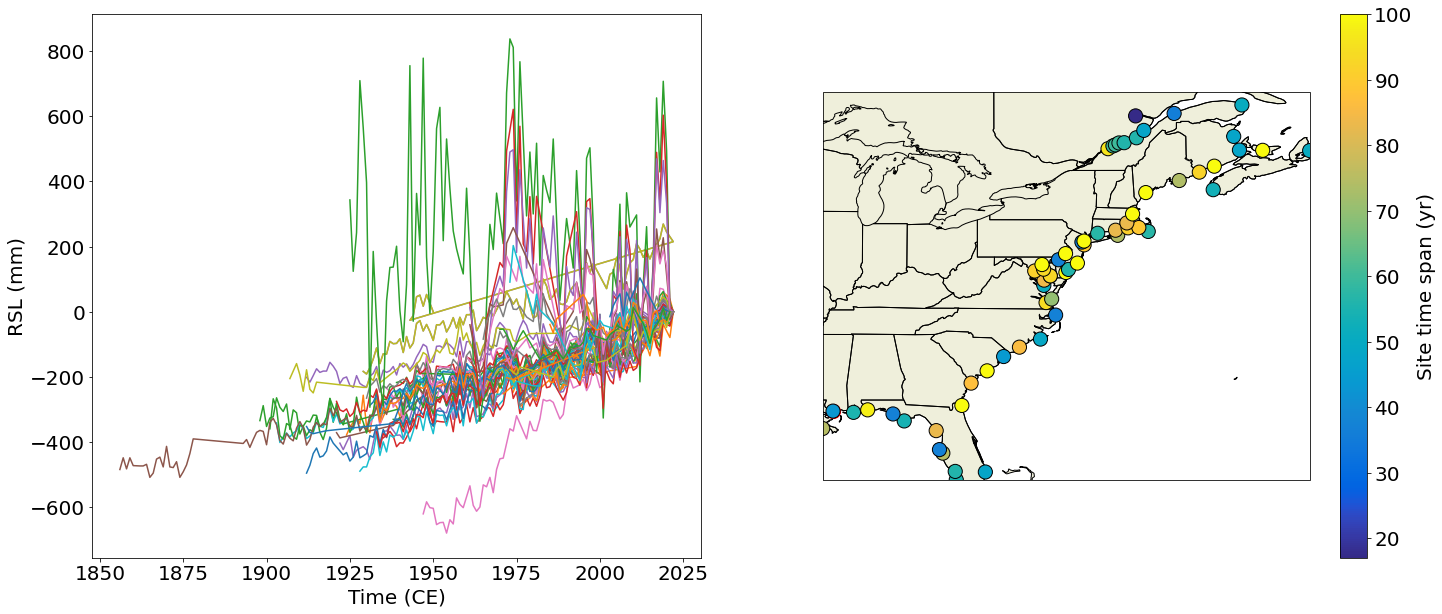

In [13]:
# #load the data, you need to define the region of interest, the minimum time span of the data, and selected data should contain data later than the latest age
US_AT_data = PSTHM.load_PSMSL_data('../../Data/TG_data',min_lat=25,max_lat=50,min_lon=-90,max_lon=-60,min_time_span=30,latest_age=2020)
US_site_coord = np.unique(US_AT_data.iloc[:,4:],axis=0)
TG_X = torch.tensor(np.vstack((US_AT_data.iloc[:,4],US_AT_data.iloc[:,5])).T)
TG_X = torch.hstack([torch.tensor(US_AT_data.iloc[:,:1].values),TG_X])
TG_y = torch.tensor(US_AT_data.iloc[:,1].values)
#-----------------plot the US Atlantic Coast RSL data-----------------
fig = plt.figure(figsize=(24,10))
gs = fig.add_gridspec(1, 2)

ax = fig.add_subplot(gs[0, :1])
for i in range(len(US_site_coord)):
    site_index = np.sum(US_AT_data.iloc[:,4:],axis=1) == np.sum(US_site_coord[i])
    ax.plot(US_AT_data[site_index].iloc[:,0],US_AT_data[site_index].iloc[:,1])
plt.xlabel('Time (CE)')
plt.ylabel('RSL (mm)')
#plot spatial data distribution, note that the size of the circle is proportional to the number of data points in the region
ax2 = fig.add_subplot(gs[0, 1:2], projection=ccrs.PlateCarree())
ax2.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0)
ax2.add_feature(cfeature.STATES, edgecolor='black', zorder=0)
ax2.set_extent([np.min(US_site_coord[:,1]),np.max(US_site_coord[:,1]),np.min(US_site_coord[:,0]),np.max(US_site_coord[:,0])])
site_time_length = []
for i in range(len(US_site_coord)):
    site_index = np.sum(US_AT_data.iloc[:,4:],axis=1) == np.sum(US_site_coord[i])
    site_time_length.append(np.max(US_AT_data[site_index].iloc[:,0])-np.min(US_AT_data[site_index].iloc[:,0]))
ax2.scatter(US_site_coord[10,1],US_site_coord[10,0],s=200,color='r')
im = ax2.scatter(US_site_coord[:,1],US_site_coord[:,0],c= site_time_length,
            s=200,transform=ccrs.PlateCarree(),zorder=1,vmax=100,cmap=parula,ec='k')
plt.colorbar(im,label='Site time span (yr)')
print('Total number of data points: ',len(TG_y));

From the plots above, you can clearly see some RSL change variability across different locations. To infer the spatio-temporal RSL change pattern based on this data, here we characterize the RSL change process with three GP kernels:

$$
k_{combined}(X,X') = k_{global}(t,t')+ k_{linear}(X,X')+k_{nonlin}(X,X')
\\

k_{global}(t,t') = k_{M3}(t,t')
\\

k_{linear}(X,X') = k_{Linear}(t,t') \times k_{M5}(x,x')
\\

k_{nonlin}(X,X') = k_{M3}(t,t') \times k_{M5}(x,x')
$$

where X indicates a data matrix contains age and coordinate of each data, with t representing the age and x representing the coordinate. `k` indicates the kernel (or covariance function) with $k_{Linear}$, $k_{M3}$ and $k_{M5}$ denotes linear, 3/2 Matérn and 5/2 Matérn kernels, respectively. This is a common way to describe spatio-temporal RSL process as in [Kopp et al., (2014)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2014EF000239), [Kopp et al., (2016)](https://www.pnas.org/doi/abs/10.1073/pnas.1517056113). 


Now even we only consider Atlantic coast data, we have 3800+ data, so the calculation can be pretty slow (200 iterations took me 8 mintues on a fairly good desktop). Let's try to do it here.

**P.S.** The default code does not train the model, instead, it will load the trained model, which is much faster. If you want to try to train it on your own computer, just de-comment the code.

In [3]:
# st = time.time() 
# pyro.clear_param_store()
# #define global temporal kernel
# global_kernel = PSTHM.Matern32(input_dim=1,geo=False)
# global_kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(30.), torch.tensor(100000.)))
# global_kernel.set_prior("variance", dist.Uniform(torch.tensor(40.**2), torch.tensor(100000.)))

# #define regionally linar spatio-temporal kernel
# regional_linear_temporal_kernel = gp.kernels.Linear(input_dim=1)
# regional_linear_temporal_kernel.set_prior("variance", dist.Uniform(torch.tensor(1e-6), torch.tensor(30.)))
# regional_linear_spatial_kernel = PSTHM.Matern52(input_dim=1,geo=True)
# regional_linear_spatial_kernel.set_prior("s_lengthscale", dist.Uniform(torch.tensor(0.05), torch.tensor(0.3)))
# regional_linear_kernel = gp.kernels.Product(regional_linear_temporal_kernel, regional_linear_spatial_kernel)

# #define regionally non-linar spatio-temporal kernel
# regional_nl_temporal_kernel = PSTHM.Matern32(input_dim=1,geo=False)
# regional_nl_temporal_kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(5.), torch.tensor(5000.)))
# regional_nl_temporal_kernel.set_prior("variance", dist.Uniform(torch.tensor(0.01), torch.tensor(40.**2)))
# regional_nl_spatial_kernel = PSTHM.Matern52(input_dim=1,geo=True)
# regional_nl_spatial_kernel.set_prior("s_lengthscale", dist.Uniform(torch.tensor(0.05), torch.tensor(0.3)))
# regional_nl_kernel = gp.kernels.Product(regional_nl_temporal_kernel, regional_nl_spatial_kernel)

# combined_sp_kernel = gp.kernels.Sum(global_kernel,regional_linear_kernel)
# combined_sp_kernel = gp.kernels.Sum(combined_sp_kernel,regional_nl_kernel)

# #-----------------define the model-----------------
# #If you don't set the noise, the model will automatically estimate the noise as the last hyperparameter
# gpr = PSTHM.GPRegression_V(TG_X, TG_y, combined_sp_kernel)


# #Empirical bayes optimization, default iteration is 1000
# gpr,track_list = PSTHM.SVI_optm(gpr,lr=0.5,num_iteration=100)

# #predict RSL for each rsl data age 
# pred_y,_ = gpr(gpr.X, full_cov=True) 

# axes = PSTHM.plot_track_list(track_list)
# et = time.time() # get the end time

# # get the execution time
# elapsed_time = et - st
# print('Execution time: {:3.3f} s'.format(elapsed_time))

# #----Save and load the trained model----
# torch.save(gpr, '../../Trained_Models/TG_SP_model')
gpr = torch.load('../../Trained_Models/TG_SP_model')


Let's check the STGP predictions as we did before.

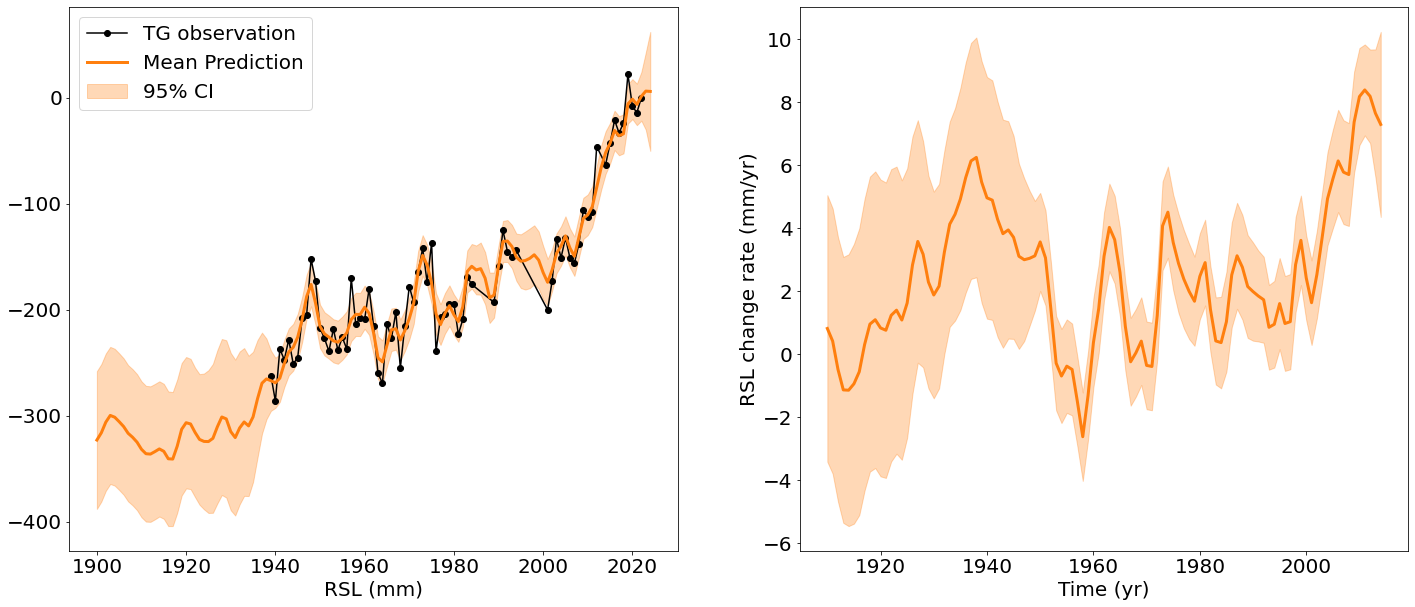

In [4]:
#generate prediction matrix
site = 5
site_index = np.sum(US_AT_data.iloc[:,4:],axis=1) == np.sum(US_site_coord[site])
test_age = np.arange(1900,2025,1)
pred_matrix = PSTHM.gen_pred_matrix(test_age,US_site_coord[site][0],US_site_coord[site][1])
y_mean, y_var = gpr(pred_matrix.double(), full_cov=True,noiseless=True)
y_std = y_var.diag().sqrt()
rsl_time,rsl_rate,rsl_rate_sd = PSTHM.cal_rate_var(test_age,y_var.detach().numpy(),y_mean.detach().numpy(),difftimestep=20)

#plot the prediction
fig = plt.figure(figsize=(24,10))
plt.subplot(121)
plt.plot(US_AT_data[site_index].iloc[:,0],US_AT_data[site_index].iloc[:,1],'ko-',label='TG observation')
plt.plot(test_age,y_mean.detach().numpy(),color='C1',linewidth=3,label='Mean Prediction')
plt.fill_between(test_age,y_mean.detach().numpy()-2*y_std.detach().numpy(),y_mean.detach().numpy()+2*y_std.detach().numpy(),color='C1',alpha=0.3,label='95% CI')
plt.xlabel('Time (yr)')
plt.xlabel('RSL (mm)')
plt.legend()
plt.subplot(122)
plt.plot(rsl_time,rsl_rate,'C1',linewidth=3,label='Mean Prediction')
plt.fill_between(rsl_time,rsl_rate-2*rsl_rate_sd,rsl_rate+2*rsl_rate_sd,color='C1',alpha=0.3,label='95% CI')
plt.xlabel('Time (yr)')
plt.ylabel('RSL change rate (mm/yr)');


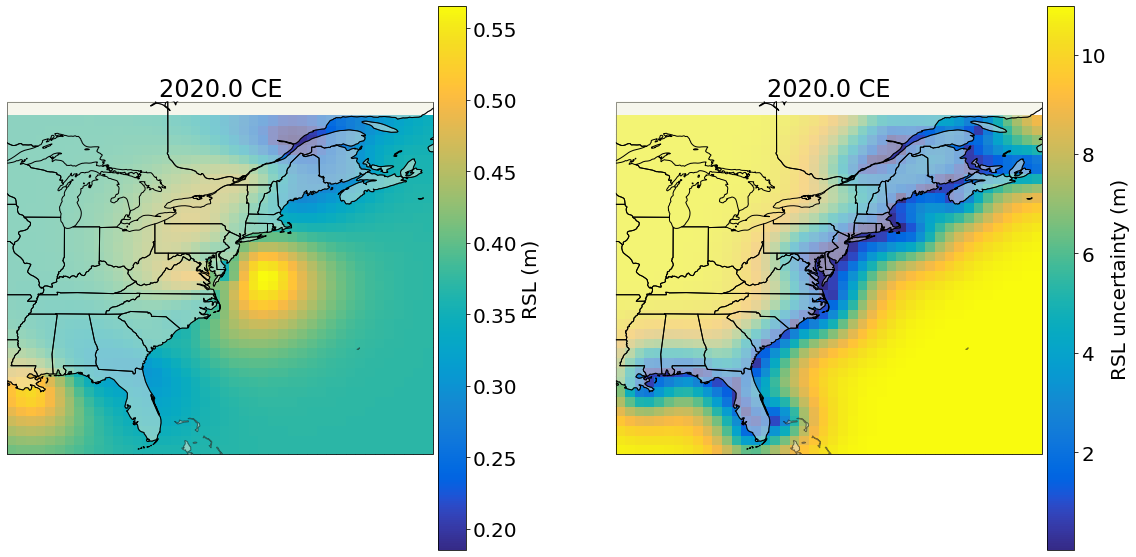

In [5]:
lat_matrix = np.arange(np.min(US_site_coord[:,0])-2,np.max(US_site_coord[:,0])+2,0.75)
lon_matrix = np.arange(np.min(US_site_coord[:,1])-2,np.max(US_site_coord[:,1])+2,0.75)
lon_mat,lat_mat = np.meshgrid(lon_matrix,lat_matrix)
pred_matrix = PSTHM.gen_pred_matrix([2020],lat_matrix,lon_matrix)
pred_matrix2 = PSTHM.gen_pred_matrix([1900],lat_matrix,lon_matrix)

y_mean, y_var = gpr(pred_matrix, full_cov=True,noiseless=False)
y_mean2, y_var2 = gpr(pred_matrix2, full_cov=True,noiseless=False)

y_std = y_var.diag().sqrt()
parula=nmmn.plots.parulacmap() # for MATLAB's cmap

fig = PSTHM.plot_spatial_rsl_single(pred_matrix,(y_mean-y_mean2)/1000,y_var/1e6,cmap=parula)

It seems like our STGP predict the largest variability in New York State where former North American Ice Sheet boundary located at. AS we consider a linear and an non-linear spatial kernel, it would be good to understand each kernel's contribution to this variability.

### 2. Spatio-temporal kernel decomposition
A good thing about using different spatio-temporal GP kernels is that we can actually decompose the spatial temporal signal, which is a powerful tool to interpret sea-level change pattern

You can do this simply in PSTHM with function `PSTHM.decompose_kernels`, where you can put in the GP regression object along with a predcition_matrix, which specific the time and location you want to decompose the kernel. And lastly, this function requires a list of kernels you want to decompose.

In this case, each spatio-temporal or temporal kernel's effect on sea-level change can be isolated. Let's start with decompose temporal singal.

In [6]:
site = 40
site_index = np.sum(US_AT_data.iloc[:,4:],axis=1) == np.sum(US_site_coord[site])
test_age = np.arange(1900,2025,1)
pred_matrix = PSTHM.gen_pred_matrix(test_age,US_site_coord[site][0],US_site_coord[site][1])

y_mean, y_var = gpr(pred_matrix, full_cov=True,noiseless=False)

#-----------------define the kernel to decompose-----------------
global_kernel = gpr.kernel.kern0.kern0
regional_linear_kernel = gpr.kernel.kern0.kern1
regional_nl_kernel = gpr.kernel.kern1

#-----------------decompose the kernel-----------------
global_dep,reigonal_linear_dep,regional_nl_dep = PSTHM.decompose_kernels(gpr,pred_matrix,[global_kernel,regional_linear_kernel,regional_nl_kernel])
global_mean,global_var = global_dep
global_std = global_var.diag().sqrt()

regional_linear_mean,regional_linear_var = reigonal_linear_dep
regional_linear_std = regional_linear_var.diag().sqrt()

regional_nl_mean,regional_nl_var = regional_nl_dep
regional_nl_std = regional_nl_var.diag().sqrt()

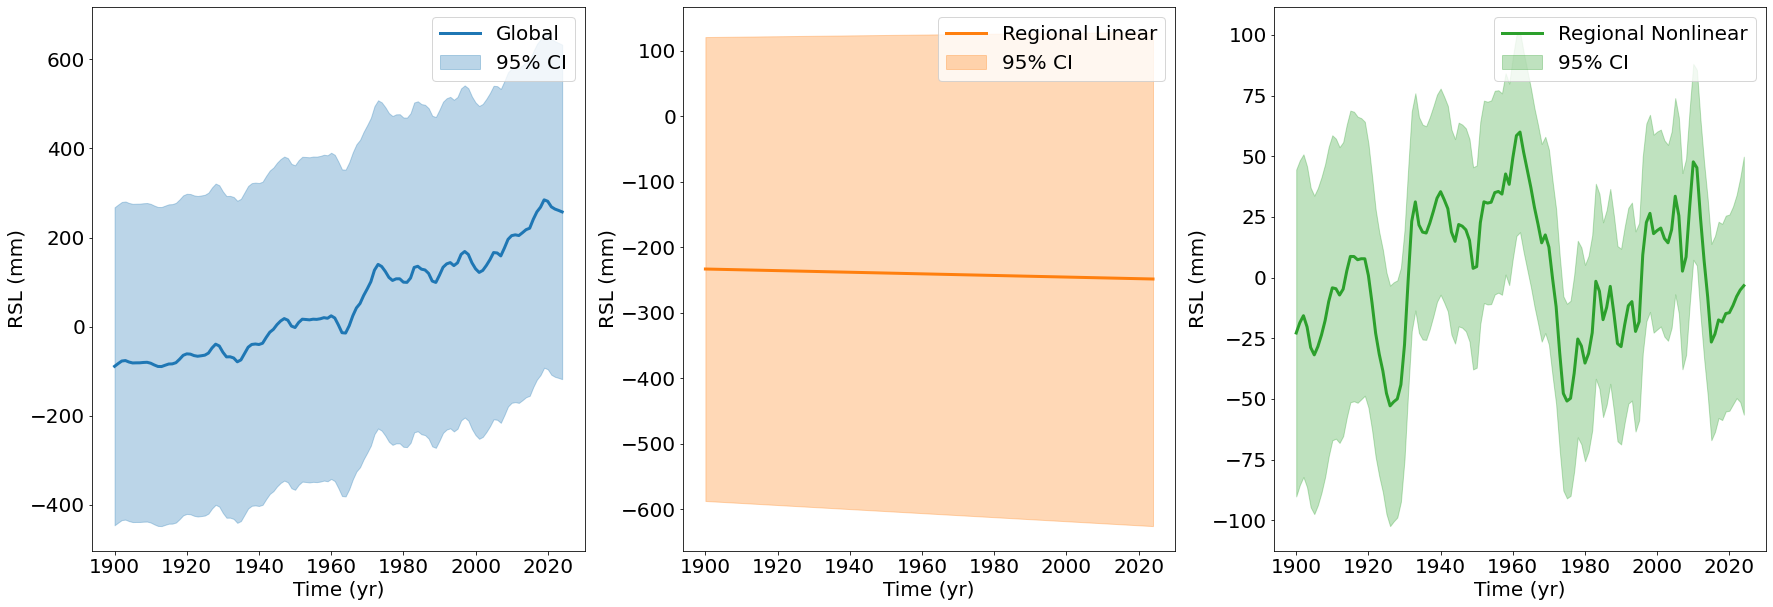

In [7]:
plt.figure(figsize=(30,10))
plt.subplot(131)
plt.plot(test_age,global_mean.detach().numpy(),'C0',linewidth=3,label='Global')
plt.fill_between(test_age,global_mean.detach().numpy()-2*global_std.detach().numpy(),global_mean.detach().numpy()+2*global_std.detach().numpy(),color='C0',alpha=0.3,label='95% CI')
plt.xlabel('Time (yr)')
plt.ylabel('RSL (mm)')
plt.legend()
plt.subplot(132)
plt.plot(test_age,regional_linear_mean.detach().numpy(),'C1',linewidth=3,label='Regional Linear')
plt.fill_between(test_age,regional_linear_mean.detach().numpy()-2*regional_linear_std.detach().numpy(),regional_linear_mean.detach().numpy()+2*regional_linear_std.detach().numpy(),color='C1',alpha=0.3,label='95% CI')
plt.xlabel('Time (yr)')
plt.ylabel('RSL (mm)')
plt.legend()
plt.subplot(133)
plt.plot(test_age,regional_nl_mean.detach().numpy(),'C2',linewidth=3,label='Regional Nonlinear')
plt.fill_between(test_age,regional_nl_mean.detach().numpy()-2*regional_nl_std.detach().numpy(),regional_nl_mean.detach().numpy()+2*regional_nl_std.detach().numpy(),color='C2',alpha=0.3,label='95% CI')
plt.xlabel('Time (yr)')
plt.ylabel('RSL (mm)')
plt.legend();

By decomposing three different components, we can tell more stories about RSL change at this specific tide gauge sites in western Florida, where most of RSL change here can be explained by a global component (i.e., shared component for every site) showing continuous RSL change perhaps due to themosteric effect, global ice sheet/glacier melting etc. 

The regional linear is quite minor here while the regional non-linear component is 

Decompose spatial field of RSL change is pretty much the same as temporal field. As all tide gauge sites share the same global component, we don't need to decompose that for spatial field. Therefore, let's just predict the spatial RSL change between 1900 and 2020 for regional linear and regional non-linear GP kernels. 


In [8]:
lat_matrix = np.arange(np.min(US_site_coord[:,0])-2,np.max(US_site_coord[:,0])+2,0.75) # 0.5 degree spatial resolution
lon_matrix = np.arange(np.min(US_site_coord[:,1])-2,np.max(US_site_coord[:,1])+2,0.75)
lon_mat,lat_mat = np.meshgrid(lon_matrix,lat_matrix)
pred_matrix = PSTHM.gen_pred_matrix([2020],lat_matrix,lon_matrix)
pred_matrix2 = PSTHM.gen_pred_matrix([1900],lat_matrix,lon_matrix)
y_mean, y_var = gpr(pred_matrix, full_cov=True,noiseless=False)

#-----------------define the kernel to decompose-----------------
global_kernel = gpr.kernel.kern0.kern0
regional_linear_kernel = gpr.kernel.kern0.kern1
regional_nl_kernel = gpr.kernel.kern1

#-----------------decompose the kernel-----------------
reigonal_linear_dep,regional_nl_dep = PSTHM.decompose_kernels(gpr,pred_matrix,[regional_linear_kernel,regional_nl_kernel])
reigonal_linear_dep2,regional_nl_dep2 = PSTHM.decompose_kernels(gpr,pred_matrix2,[regional_linear_kernel,regional_nl_kernel])

regional_linear_mean,regional_linear_var = reigonal_linear_dep
regional_linear_mean2,regional_linear_var2 = reigonal_linear_dep2
regional_linear_std = regional_linear_var.diag().sqrt()
regional_linear_std2 = regional_linear_var2.diag().sqrt()

regional_nl_mean,regional_nl_var = regional_nl_dep
regional_nl_mean2,regional_nl_var2 = regional_nl_dep2
regional_nl_std = regional_nl_var.diag().sqrt()
regional_nl_std2 = regional_nl_var2.diag().sqrt()

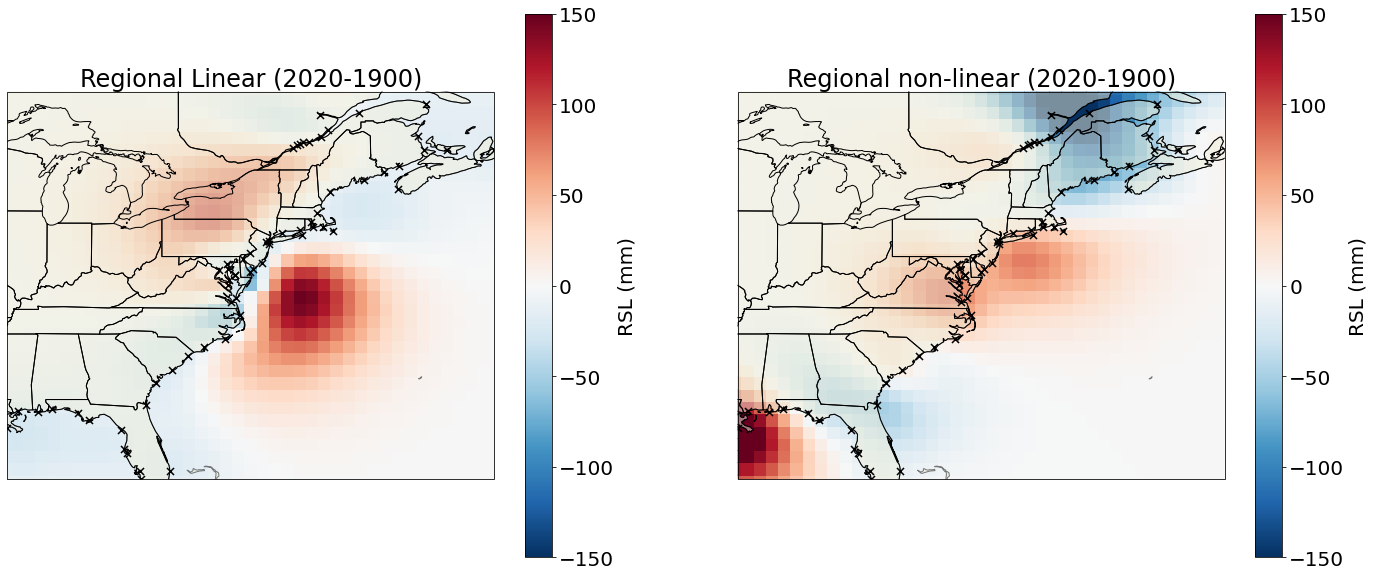

In [9]:
plt.figure(figsize=(24,10))
ax2 = plt.subplot(121,projection=ccrs.PlateCarree())
ax2.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0,alpha=0.5)
ax2.add_feature(cfeature.STATES, edgecolor='black', zorder=0)
ax2.set_extent([np.min(US_site_coord[:,1]),np.max(US_site_coord[:,1]),np.min(US_site_coord[:,0]),np.max(US_site_coord[:,0])])
im = ax2.pcolor(lon_mat,lat_mat,(regional_linear_mean-regional_linear_mean2).detach().numpy().reshape(lat_mat.shape),cmap='RdBu_r',zorder=-1,
                vmax=150,vmin=-150)
plt.colorbar(im,ax=ax2,label='RSL (mm)')
plt.title('Regional Linear (2020-1900)')

ax2.scatter(US_site_coord[:,1],US_site_coord[:,0],c='k',s=50,marker='x',label='TG observation')

ax2 = plt.subplot(122,projection=ccrs.PlateCarree())
ax2.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0,alpha=0.5)
ax2.add_feature(cfeature.STATES, edgecolor='black', zorder=0)
ax2.set_extent([np.min(US_site_coord[:,1]),np.max(US_site_coord[:,1]),np.min(US_site_coord[:,0]),np.max(US_site_coord[:,0])])
ax2.scatter(US_site_coord[:,1],US_site_coord[:,0],c='k',s=50,marker='x',label='TG observation')

im = ax2.pcolor(lon_mat,lat_mat,(regional_nl_mean-regional_nl_mean2).detach().numpy().reshape(lat_mat.shape),cmap='RdBu_r',zorder=-1,vmin=-150,vmax=150)
plt.colorbar(im,ax=ax2,label='RSL (mm)')
plt.title('Regional non-linear (2020-1900)');

By introducing multiple kernels in GP, we can start to infer sea-level change due to different physical phenomenon. This is quite handly in any environmental studies. 

### 3. GPU acceleration

With 3800+ data, we start to experience the computational problem for GP. A reminder that, PSTHM is built upon pyro, which uses PyTorch as a backend. In this case, we can use GPU to accelerate training process quite easily by setting all input and output variable into a cuda environment. 

To do this, you should make sure you have gpu in your comptuer, which can be checked by:


In [11]:
torch.cuda.is_available()

True

If you get a `True` output, you are good to go!


**P.S.** The default code below does not train the model, instead, it will load the trained model, which is much faster. If you want to try to train it on your own computer, just de-comment the code.

In [18]:
# st = time.time() 
# pyro.clear_param_store()
# #define global temporal kernel
# global_kernel = PSTHM.Matern32(input_dim=1,geo=False)
# global_kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(30.), torch.tensor(100000.)))
# global_kernel.set_prior("variance", dist.Uniform(torch.tensor(40.**2), torch.tensor(100000.)))

# #define regionally linar spatio-temporal kernel
# regional_linear_temporal_kernel = gp.kernels.Linear(input_dim=1)
# regional_linear_temporal_kernel.set_prior("variance", dist.Uniform(torch.tensor(1e-6), torch.tensor(30.)))
# regional_linear_spatial_kernel = PSTHM.Matern52(input_dim=1,geo=True)
# regional_linear_spatial_kernel.set_prior("s_lengthscale", dist.Uniform(torch.tensor(0.05), torch.tensor(0.3)))
# regional_linear_kernel = gp.kernels.Product(regional_linear_temporal_kernel, regional_linear_spatial_kernel)

# #define regionally non-linar spatio-temporal kernel
# regional_nl_temporal_kernel = PSTHM.Matern32(input_dim=1,geo=False)
# regional_nl_temporal_kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(5.), torch.tensor(5000.)))
# regional_nl_temporal_kernel.set_prior("variance", dist.Uniform(torch.tensor(0.01), torch.tensor(40.**2)))
# regional_nl_spatial_kernel = PSTHM.Matern52(input_dim=1,geo=True)
# regional_nl_spatial_kernel.set_prior("s_lengthscale", dist.Uniform(torch.tensor(0.05), torch.tensor(0.3)))
# regional_nl_kernel = gp.kernels.Product(regional_nl_temporal_kernel, regional_nl_spatial_kernel)

# combined_sp_kernel = gp.kernels.Sum(global_kernel,regional_linear_kernel)
# combined_sp_kernel = gp.kernels.Sum(combined_sp_kernel,regional_nl_kernel)

# #-----------------define the model-----------------
# #If you don't set the noise, the model will automatically estimate the noise as the last hyperparameter
# #note we convert X and y data to gpu here
# gpr = PSTHM.GPRegression_V(TG_X.cuda(), TG_y.cuda(), combined_sp_kernel)
# gpr = gpr.cuda()

# #Empirical bayes optimization, default iteration is 1000
# gpr,track_list = PSTHM.SVI_optm(gpr,lr=0.5,num_iteration=100)

# #predict RSL for each rsl data age 
# pred_y,_ = gpr(gpr.X, full_cov=True) 

# axes = PSTHM.plot_track_list(track_list)
# et = time.time() # get the end time

# # get the execution time
# elapsed_time = et - st
# print('Execution time: {:3.3f} s'.format(elapsed_time))

# #----Save and load the trained model----
# torch.save(gpr, '../../Trained_Models/TG_SP_model_gpu')
gpr = torch.load('../../Trained_Models/TG_SP_model_gpu')
gpr.X =gpr.X.cpu()
gpr.y =gpr.y.cpu()
gpr = gpr.cpu()

Based on a simple experiment on my desktop, using GPU will reduce the computational time from ~4.3 minutes to 2.5 minutes. And after training the model, transferring model back to cpu environment can be a good idea since cpu usually has more memory than GPU and when use GP to predict, the prediction matrix can use pretty large RAM.  

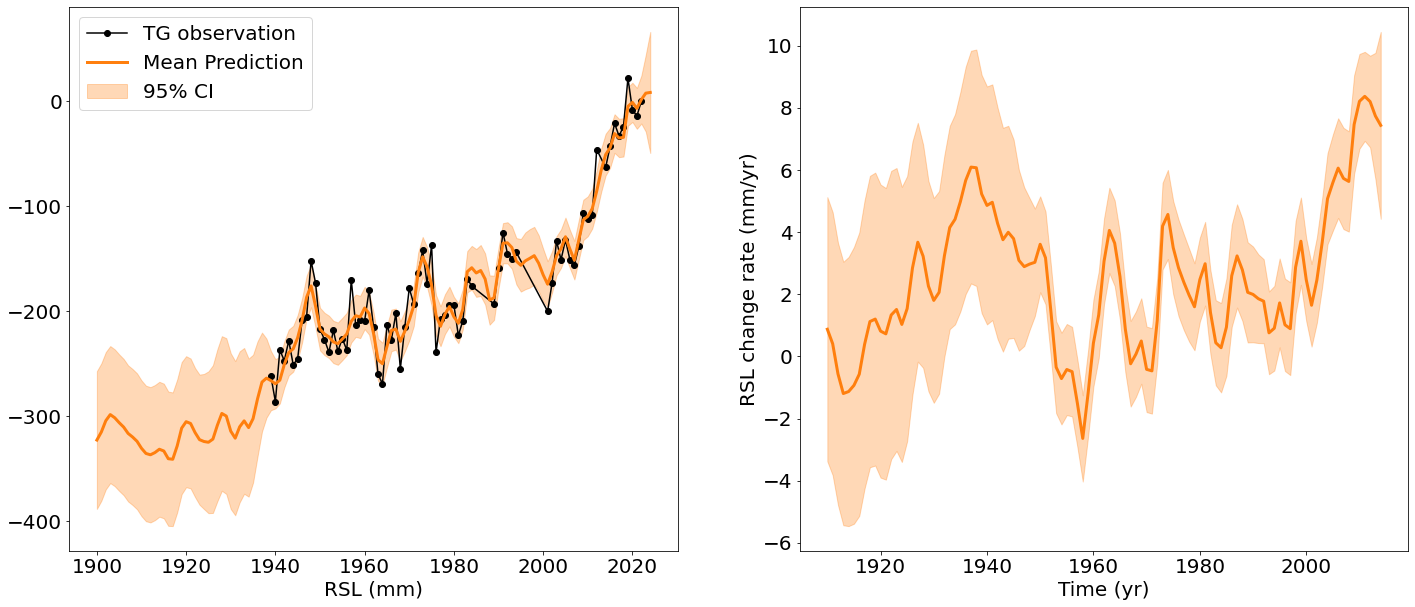

In [19]:
#generate prediction matrix
site = 5
site_index = np.sum(US_AT_data.iloc[:,4:],axis=1) == np.sum(US_site_coord[site])
test_age = np.arange(1900,2025,1)
pred_matrix = PSTHM.gen_pred_matrix(test_age,US_site_coord[site][0],US_site_coord[site][1])
y_mean, y_var = gpr(pred_matrix.double(), full_cov=True,noiseless=True)
y_std = y_var.diag().sqrt()
rsl_time,rsl_rate,rsl_rate_sd = PSTHM.cal_rate_var(test_age,y_var.detach().numpy(),y_mean.detach().numpy(),difftimestep=20)

#plot the prediction
fig = plt.figure(figsize=(24,10))
plt.subplot(121)
plt.plot(US_AT_data[site_index].iloc[:,0],US_AT_data[site_index].iloc[:,1],'ko-',label='TG observation')
plt.plot(test_age,y_mean.detach().numpy(),color='C1',linewidth=3,label='Mean Prediction')
plt.fill_between(test_age,y_mean.detach().numpy()-2*y_std.detach().numpy(),y_mean.detach().numpy()+2*y_std.detach().numpy(),color='C1',alpha=0.3,label='95% CI')
plt.xlabel('Time (yr)')
plt.xlabel('RSL (mm)')
plt.legend()
plt.subplot(122)
plt.plot(rsl_time,rsl_rate,'C1',linewidth=3,label='Mean Prediction')
plt.fill_between(rsl_time,rsl_rate-2*rsl_rate_sd,rsl_rate+2*rsl_rate_sd,color='C1',alpha=0.3,label='95% CI')
plt.xlabel('Time (yr)')
plt.ylabel('RSL change rate (mm/yr)');


Now, you should be good to go with STGP for your own question. But a key issue still is that STGP cannot capture tele-connection, which is quite important in environmental problems. A good way to improve this problem is including physical model as a mean funciton (just as what we do in tutorial 4 for temporal GP). The next tutorial with guide you through the process of incorporating a physical process model to better infer sea-level. See you there.

Thanks for going through this tutorial, we are actively developing PaleoSTeHM now, so your feedback will be truely valueable to us. You can fill this [survey](https://forms.gle/W1DMPQY8KyAgoT9r6) to let us know what do you think about this tutorial, which will shape the future direction of PaleoSTeHM.

